In [3]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

For my own understanding:

Period is the time it takes for the object to orbit the earth once
Inclination is the angle between plane of orbit and equatorial plane of Earth?
Apogee is the point during orbit at which the object is farthest from Earth
Perigee is the point during orbit at which the object is closest to Earth

In [4]:
# ogDF is the original dataframe, df is the cleaned dataframe
ogDF = pl.read_csv('satcat.csv')
ogDF.head()

INTLDES,NORAD_CAT_ID,OBJECT_TYPE,SATNAME,COUNTRY,LAUNCH,SITE,DECAY,PERIOD,INCLINATION,APOGEE,PERIGEE,COMMENT,COMMENTCODE,RCSVALUE,RCS_SIZE,FILE,LAUNCH_YEAR,LAUNCH_NUM,LAUNCH_PIECE,CURRENT,OBJECT_NAME,OBJECT_ID,OBJECT_NUMBER
str,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,i64,i64,str,str,str,str,i64
"""1957-001A""",1,"""ROCKET BODY""","""SL-1 R/B""","""CIS""","""1957-10-04""","""TTMTR""","""1957-12-01""","""96.19""","""65.10""","""938""","""214""","""""","""4""",0,"""LARGE""",1,1957,1,"""A""","""Y""","""SL-1 R/B""","""1957-001A""",1
"""1957-001B""",2,"""PAYLOAD""","""SPUTNIK 1""","""CIS""","""1957-10-04""","""TTMTR""","""1958-01-03""","""96.10""","""65.00""","""1080""","""64""","""""","""""",0,"""""",7179,1957,1,"""B""","""Y""","""SPUTNIK 1""","""1957-001B""",2
"""1957-002A""",3,"""PAYLOAD""","""SPUTNIK 2""","""CIS""","""1957-11-03""","""TTMTR""","""1958-04-14""","""103.74""","""65.33""","""1659""","""211""","""""","""""",0,"""SMALL""",8685,1957,2,"""A""","""Y""","""SPUTNIK 2""","""1957-002A""",3
"""1958-001A""",4,"""PAYLOAD""","""EXPLORER 1""","""US""","""1958-02-01""","""AFETR""","""1970-03-31""","""88.48""","""33.15""","""215""","""183""","""""","""""",0,"""""",1,1958,1,"""A""","""Y""","""EXPLORER 1""","""1958-001A""",4
"""1958-002A""",16,"""ROCKET BODY""","""VANGUARD R/B""","""US""","""1958-03-17""","""AFETR""","""""","""137.21""","""34.26""","""4217""","""651""","""""","""""",0,"""MEDIUM""",8932,1958,2,"""A""","""Y""","""VANGUARD R/B""","""1958-002A""",16


In [5]:
# Clean dataset
df = ogDF.with_columns([
    pl.col("DECAY").str.strptime(pl.Date, "%Y-%m-%d", strict=False).alias("DECAY"),
    pl.col("LAUNCH").str.strptime(pl.Date, "%Y-%m-%d", strict=False).alias("LAUNCH")
])
current_date = pl.lit(datetime.now()).cast(pl.Date)
df = df.with_columns([
    (pl.when(pl.col("DECAY").is_not_null())
     .then((pl.col("DECAY") - pl.col("LAUNCH")).cast(pl.Int64) / (1000 * 60 * 60 * 24))
     .otherwise((current_date - pl.col("LAUNCH")).cast(pl.Int64) / (1000 * 60 * 60 * 24)))
    .alias("DECAY_TIME")
])

df = df.filter(
    (df["PERIOD"] != "") &
    (df["INCLINATION"] != "") &
    (df["APOGEE"] != "") &
    (df["PERIGEE"] != "")
)

df = df.with_columns([
    df["PERIOD"].cast(pl.Float64),
    df["INCLINATION"].cast(pl.Float64),
    df["APOGEE"].cast(pl.Float64),
    df["PERIGEE"].cast(pl.Float64)
])

df.head(10)

INTLDES,NORAD_CAT_ID,OBJECT_TYPE,SATNAME,COUNTRY,LAUNCH,SITE,DECAY,PERIOD,INCLINATION,APOGEE,PERIGEE,COMMENT,COMMENTCODE,RCSVALUE,RCS_SIZE,FILE,LAUNCH_YEAR,LAUNCH_NUM,LAUNCH_PIECE,CURRENT,OBJECT_NAME,OBJECT_ID,OBJECT_NUMBER,DECAY_TIME
str,i64,str,str,str,date,str,date,f64,f64,f64,f64,str,str,i64,str,i64,i64,i64,str,str,str,str,i64,f64
"""1957-001A""",1,"""ROCKET BODY""","""SL-1 R/B""","""CIS""",1957-10-04,"""TTMTR""",1957-12-01,96.19,65.1,938.0,214.0,"""""","""4""",0,"""LARGE""",1,1957,1,"""A""","""Y""","""SL-1 R/B""","""1957-001A""",1,58.0
"""1957-001B""",2,"""PAYLOAD""","""SPUTNIK 1""","""CIS""",1957-10-04,"""TTMTR""",1958-01-03,96.1,65.0,1080.0,64.0,"""""","""""",0,"""""",7179,1957,1,"""B""","""Y""","""SPUTNIK 1""","""1957-001B""",2,91.0
"""1957-002A""",3,"""PAYLOAD""","""SPUTNIK 2""","""CIS""",1957-11-03,"""TTMTR""",1958-04-14,103.74,65.33,1659.0,211.0,"""""","""""",0,"""SMALL""",8685,1957,2,"""A""","""Y""","""SPUTNIK 2""","""1957-002A""",3,162.0
"""1958-001A""",4,"""PAYLOAD""","""EXPLORER 1""","""US""",1958-02-01,"""AFETR""",1970-03-31,88.48,33.15,215.0,183.0,"""""","""""",0,"""""",1,1958,1,"""A""","""Y""","""EXPLORER 1""","""1958-001A""",4,4441.0
"""1958-002A""",16,"""ROCKET BODY""","""VANGUARD R/B""","""US""",1958-03-17,"""AFETR""",null,137.21,34.26,4217.0,651.0,"""""","""""",0,"""MEDIUM""",8932,1958,2,"""A""","""Y""","""VANGUARD R/B""","""1958-002A""",16,24344.0
"""1958-002B""",5,"""PAYLOAD""","""VANGUARD 1""","""US""",1958-03-17,"""AFETR""",null,132.63,34.25,3825.0,649.0,"""""","""""",0,"""SMALL""",8935,1958,2,"""B""","""Y""","""VANGUARD 1""","""1958-002B""",5,24344.0
"""1958-002C""",1576,"""DEBRIS""","""VANGUARD DEB""","""US""",1958-03-17,"""AFETR""",null,122.28,34.22,2927.0,639.0,"""""","""""",0,"""SMALL""",8935,1958,2,"""C""","""Y""","""VANGUARD DEB""","""1958-002C""",1576,24344.0
"""1958-003A""",6,"""PAYLOAD""","""EXPLORER 3""","""US""",1958-03-26,"""AFETR""",1958-06-28,103.6,33.5,1739.0,117.0,"""""","""5""",0,"""""",1,1958,3,"""A""","""Y""","""EXPLORER 3""","""1958-003A""",6,94.0
"""1958-004A""",7,"""ROCKET BODY""","""SL-1 R/B""","""CIS""",1958-05-15,"""TTMTR""",1958-12-03,102.74,65.14,1571.0,206.0,"""""","""""",0,"""""",1,1958,4,"""A""","""Y""","""SL-1 R/B""","""1958-004A""",7,202.0


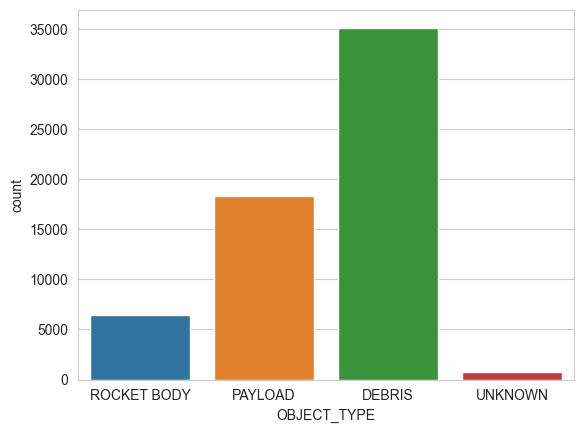

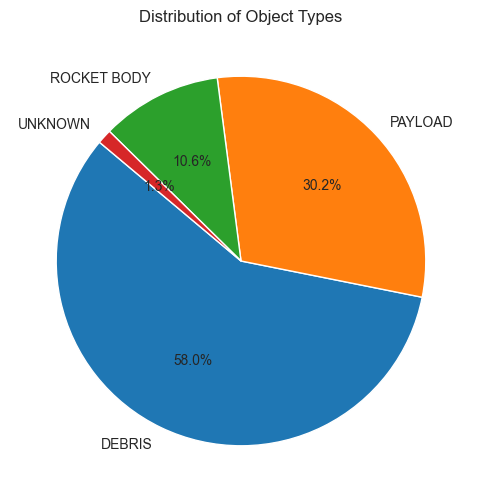

In [6]:
sns.countplot(data=df.to_pandas(), x="OBJECT_TYPE")
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(df.to_pandas()['OBJECT_TYPE'].value_counts(), labels=df.to_pandas()['OBJECT_TYPE'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Object Types')
plt.show()

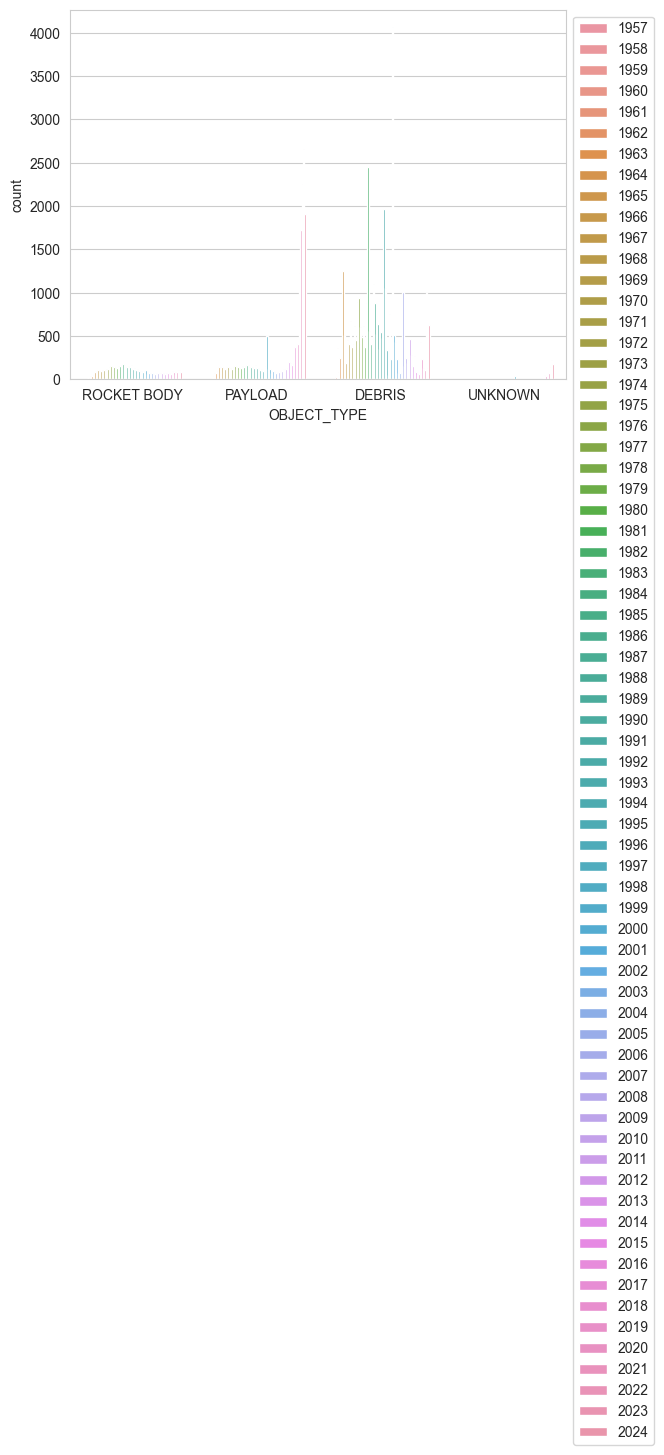

In [7]:
sns.countplot(data=df.to_pandas(), x="OBJECT_TYPE", hue="LAUNCH_YEAR")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

<AxesSubplot: >

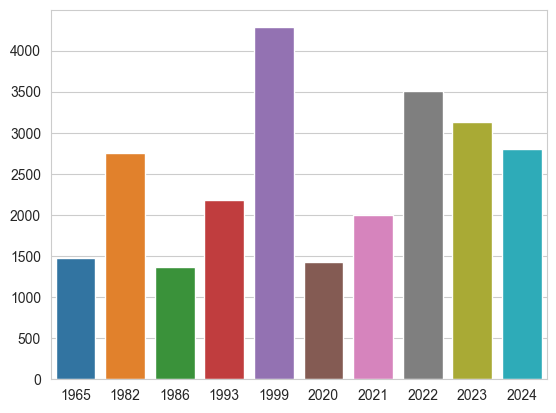

In [8]:
sns.barplot(data=df.to_pandas(), x=df.to_pandas()['LAUNCH_YEAR'].value_counts().sort_values(ascending=False).head(10).index, y=df.to_pandas()['LAUNCH_YEAR'].value_counts().sort_values(ascending=False).head(10).values)

In [9]:
# Create 4 diff datasets depending on object type
rocket_body_df = df.filter(df["OBJECT_TYPE"] == "ROCKET BODY")
payload_df = df.filter(df["OBJECT_TYPE"] == "PAYLOAD")
debris_df = df.filter(df["OBJECT_TYPE"] == "DEBRIS")
unknown_df = df.filter(df["OBJECT_TYPE"] == "UNKNOWN")

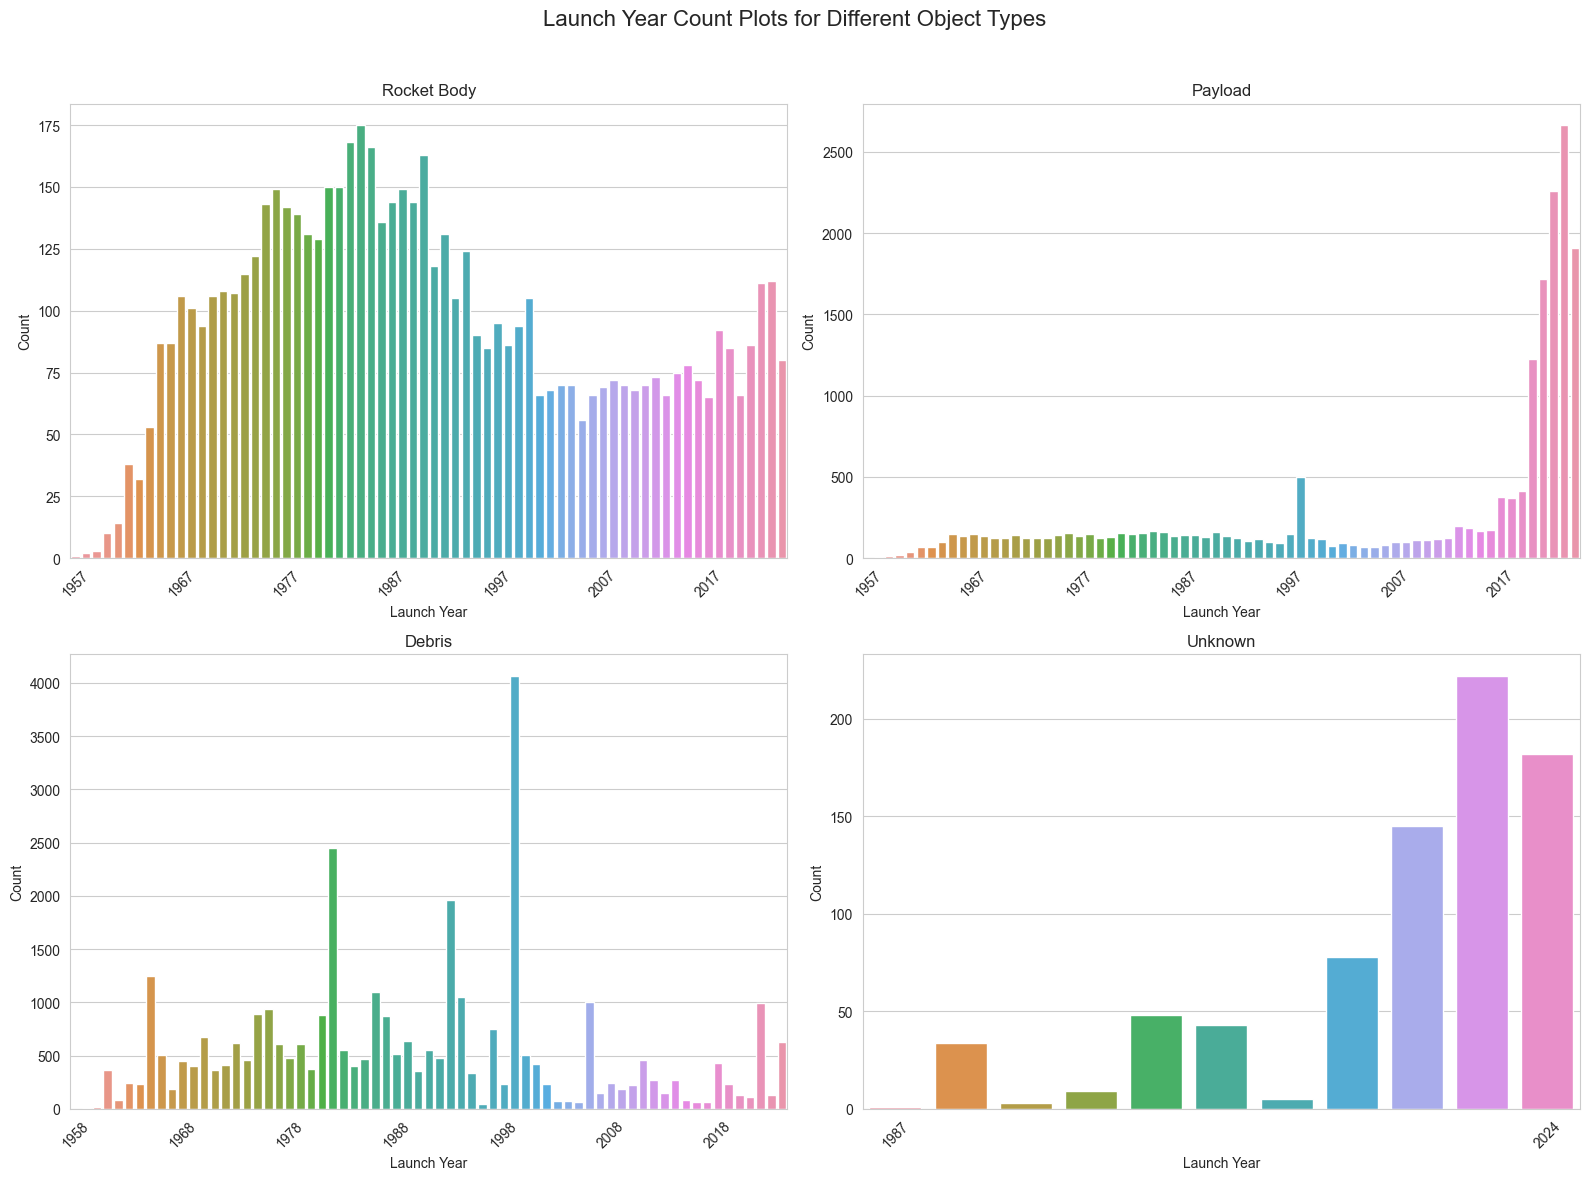

In [10]:
rocket_body_df = rocket_body_df.to_pandas()
payload_df = payload_df.to_pandas()
debris_df = debris_df.to_pandas()
unknown_df = unknown_df.to_pandas()

fig, axes = plt.subplots(2, 2, figsize=(16, 12)) # to create a 2x2 grid to hold all of it in one nice and tidy graph
fig.suptitle('Launch Year Count Plots for Different Object Types', fontsize=16)

dfs = [(rocket_body_df, 'Rocket Body'),
       (payload_df, 'Payload'),
       (debris_df, 'Debris'),
       (unknown_df, 'Unknown')]

for ax, (data, title) in zip(axes.flatten(), dfs):
    sns.countplot(data=data, x="LAUNCH_YEAR", ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Launch Year')
    ax.set_ylabel('Count')
    
    ax.set_xticks(ax.get_xticks()[::10]) 
    ax.tick_params(axis='x', rotation=45) 

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

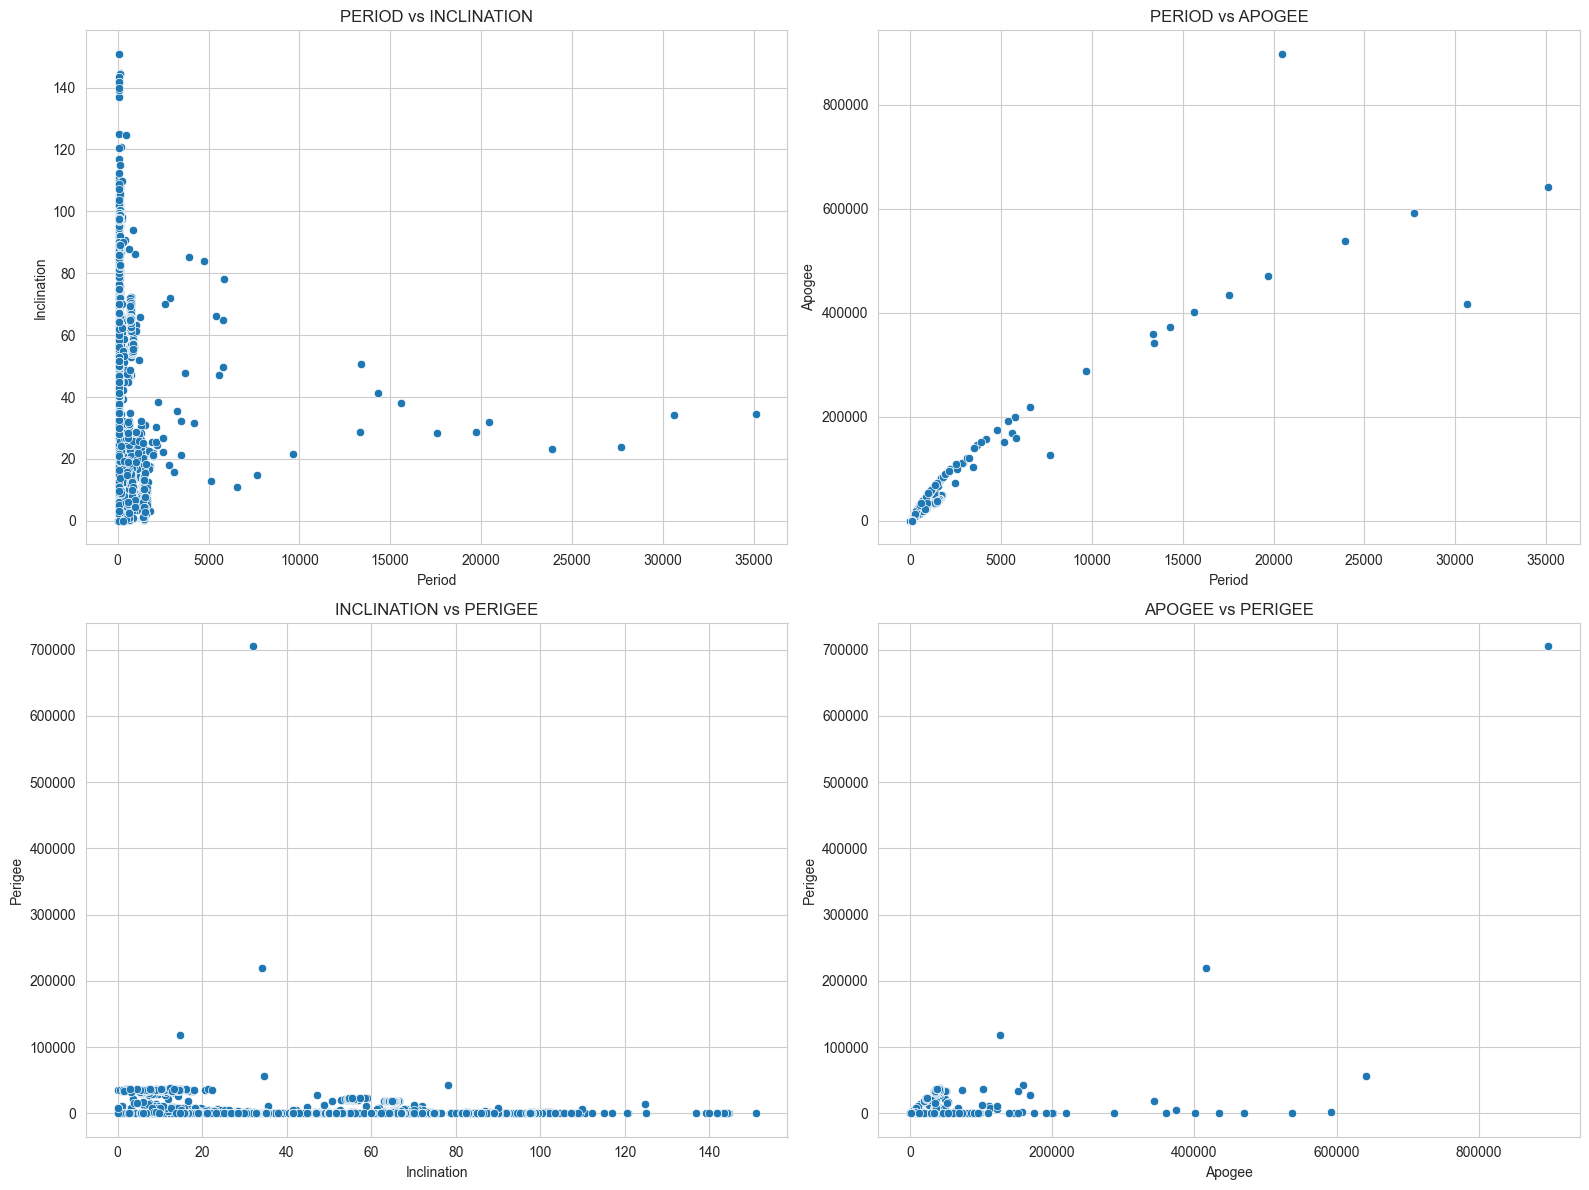

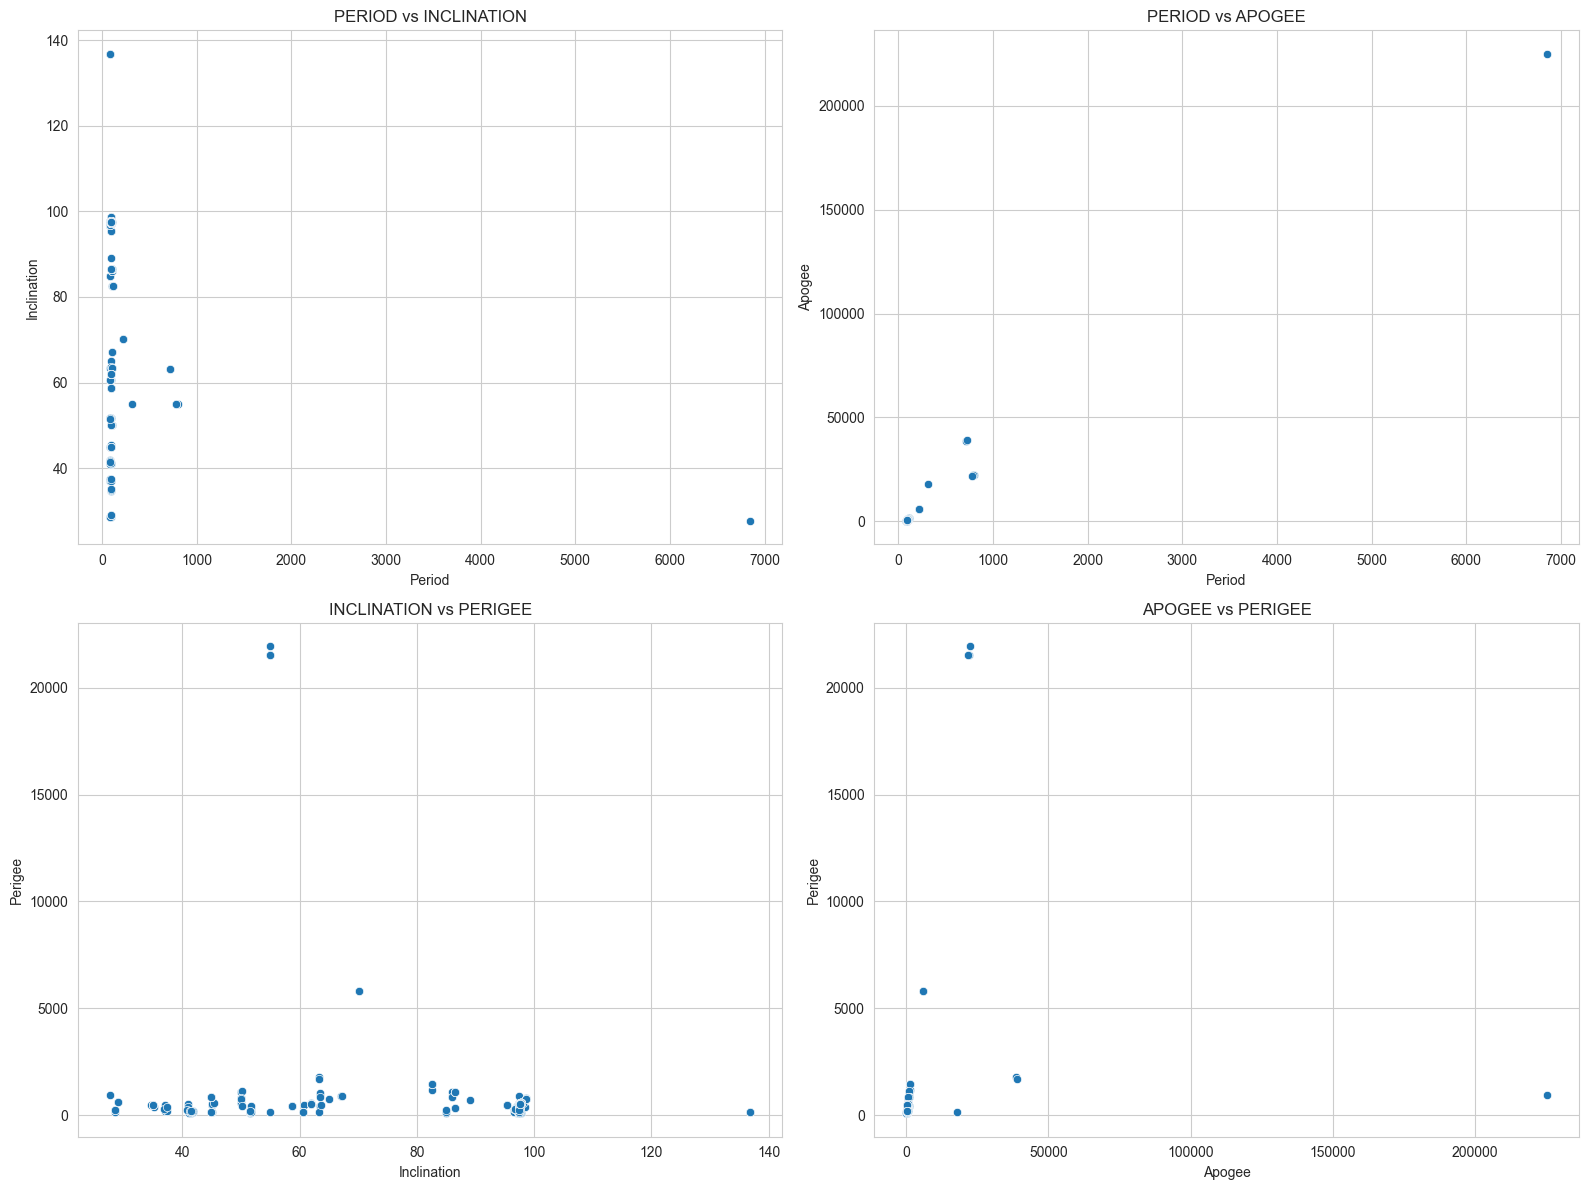

In [11]:
x_vars = ['PERIOD', 'PERIOD', 'INCLINATION', 'APOGEE']
y_vars = ['INCLINATION', 'APOGEE', 'PERIGEE', 'PERIGEE']
titles = ['PERIOD vs INCLINATION', 'PERIOD vs APOGEE', 'INCLINATION vs PERIGEE', 'APOGEE vs PERIGEE']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, x_var, y_var, title in zip(axes.ravel(), x_vars, y_vars, titles):
    sns.scatterplot(data=rocket_body_df, x=x_var, y=y_var, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_var.capitalize())
    ax.set_ylabel(y_var.capitalize())

plt.tight_layout()
plt.show()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, x_var, y_var, title in zip(axes.ravel(), x_vars, y_vars, titles):
    sns.scatterplot(data=unknown_df, x=x_var, y=y_var, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_var.capitalize())
    ax.set_ylabel(y_var.capitalize())

plt.tight_layout()
plt.show()

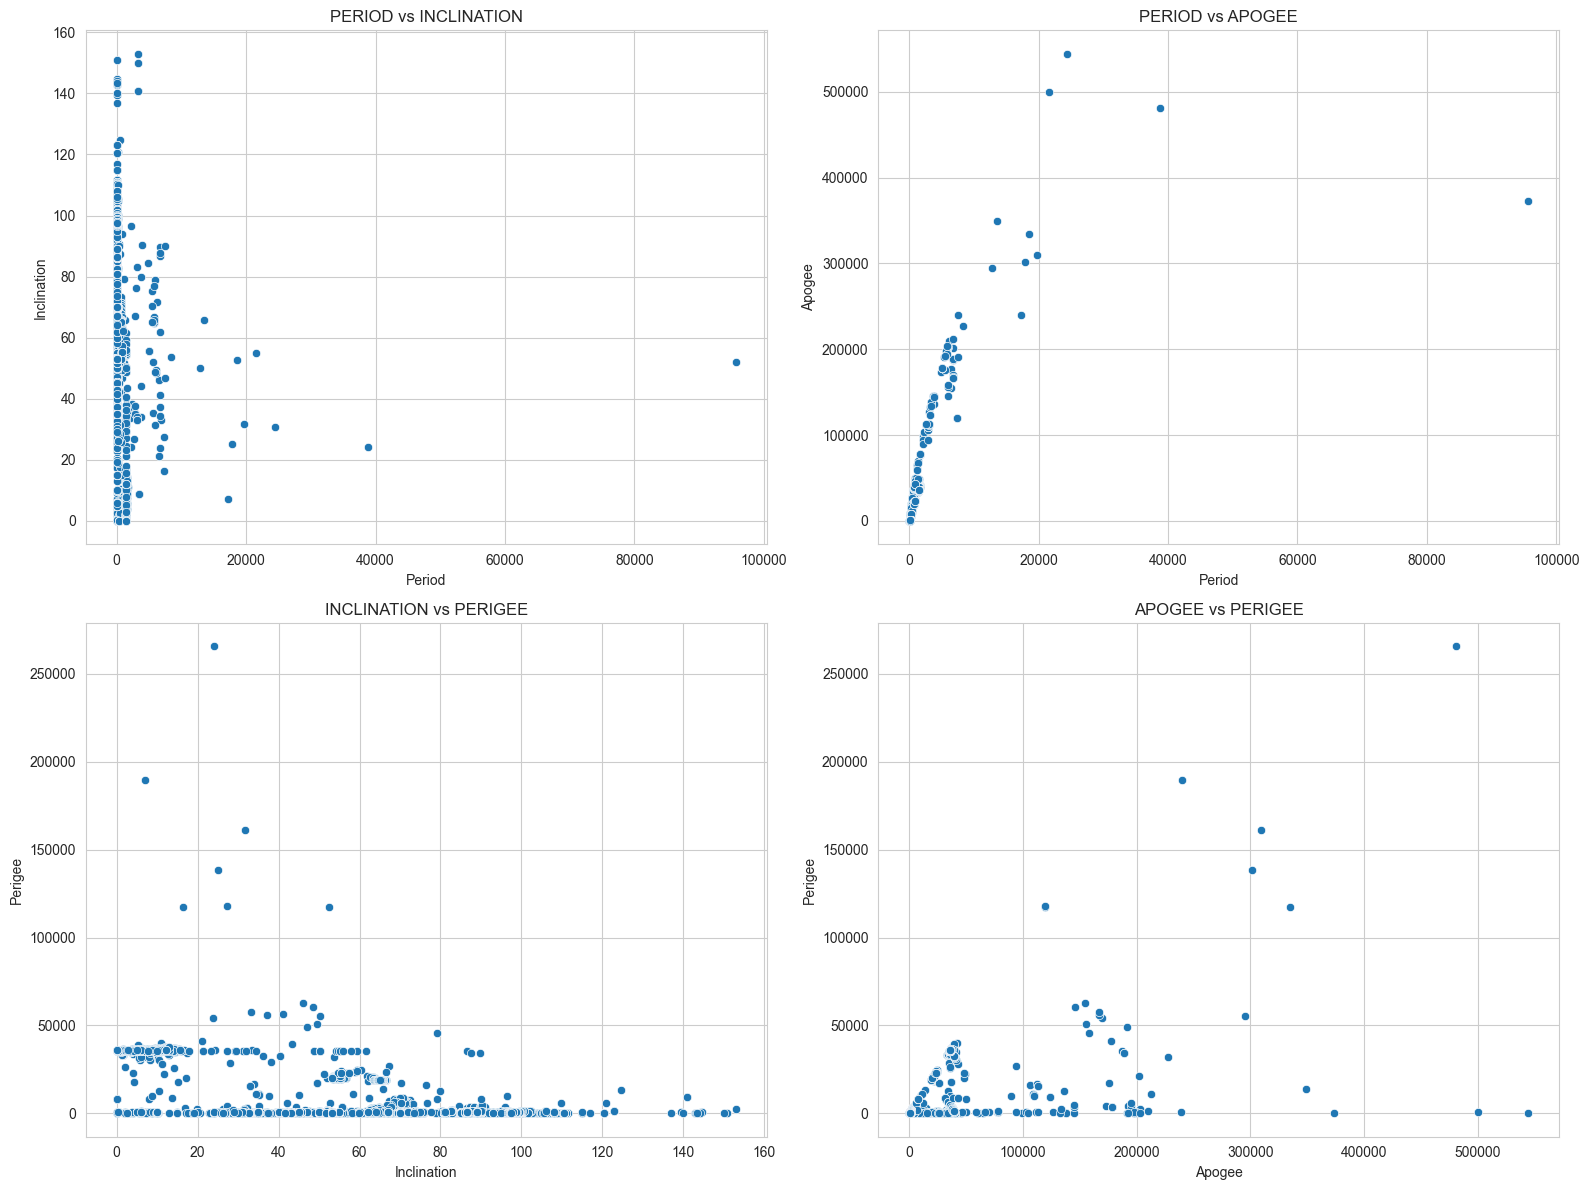

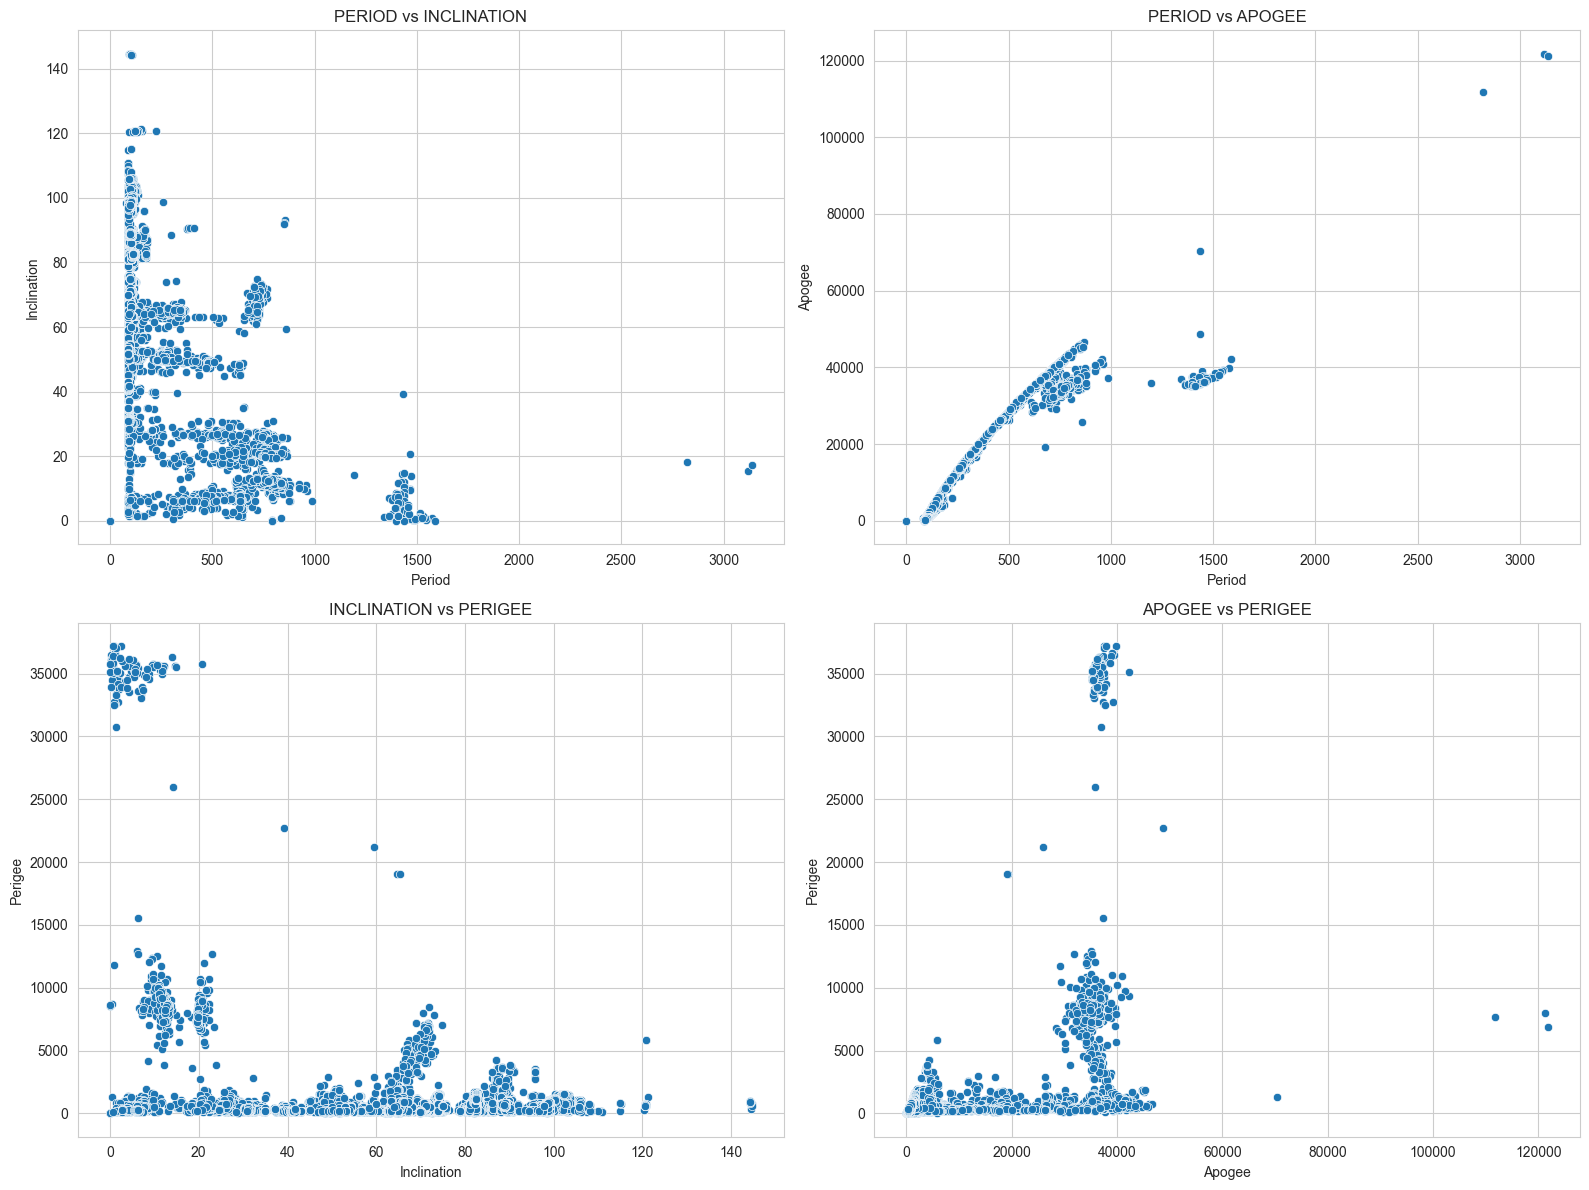

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, x_var, y_var, title in zip(axes.ravel(), x_vars, y_vars, titles):
    sns.scatterplot(data=payload_df, x=x_var, y=y_var, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_var.capitalize())
    ax.set_ylabel(y_var.capitalize())

plt.tight_layout()
plt.show()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, x_var, y_var, title in zip(axes.ravel(), x_vars, y_vars, titles):
    sns.scatterplot(data=debris_df, x=x_var, y=y_var, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_var.capitalize())
    ax.set_ylabel(y_var.capitalize())

plt.tight_layout()
plt.show()

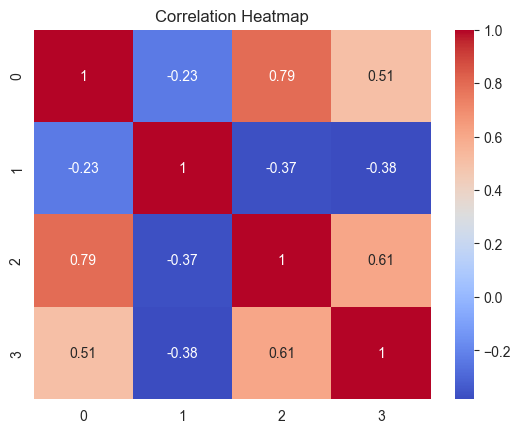

In [13]:
sns.heatmap(df[['PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


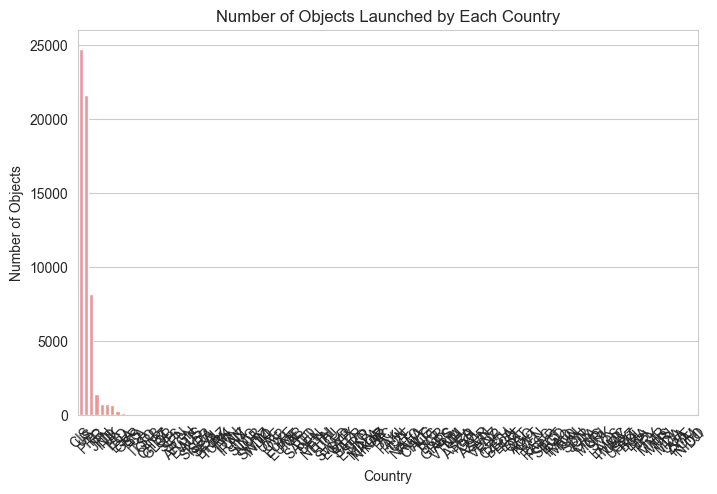

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df.to_pandas(),
    x="COUNTRY",
    order=df.to_pandas()['COUNTRY'].value_counts().loc[lambda x: x > 0].index
)
plt.title('Number of Objects Launched by Each Country')
plt.xlabel('Country')
plt.ylabel('Number of Objects')
plt.xticks(rotation=45)
plt.show()

In [15]:
df.filter(pl.col('OBJECT_TYPE') == 'PAYLOAD').select('COUNTRY').to_series().value_counts()

COUNTRY,count
str,u32
"""NATO""",8
"""MNG""",1
"""IT""",77
"""CA""",94
"""SAFR""",11
…,…
"""SVN""",3
"""SDN""",1
"""ZWE""",1


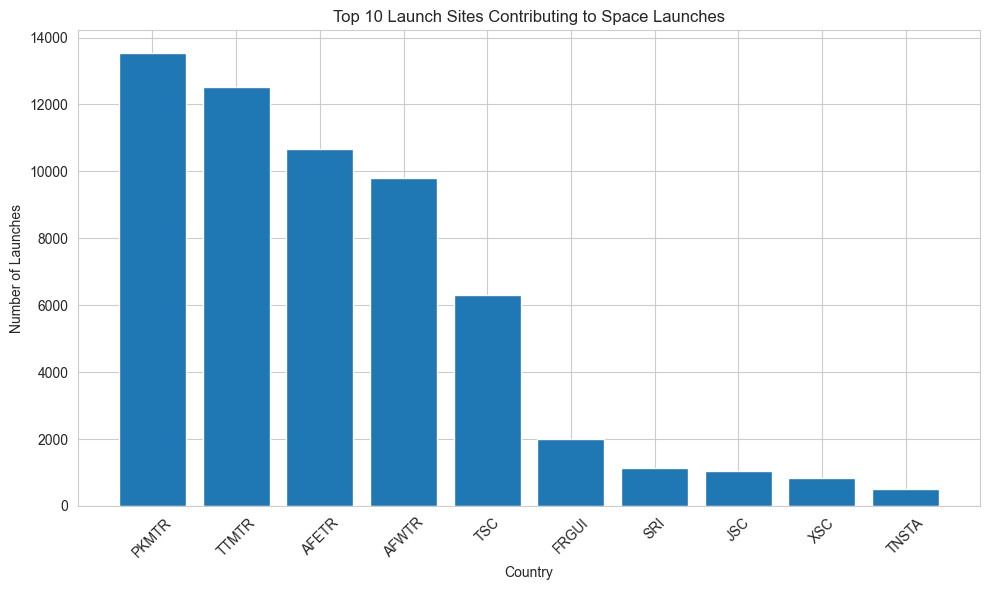

In [18]:
launch_count_by_site = df["SITE"].value_counts()

top_10_site = launch_count_by_site.sort("count", descending=True).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_site.to_pandas()['SITE'],top_10_site.to_pandas()['count'])
plt.xlabel('Country')
plt.ylabel('Number of Launches')
plt.title('Top 10 Launch Sites Contributing to Space Launches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

['COUNTRY', 'count']


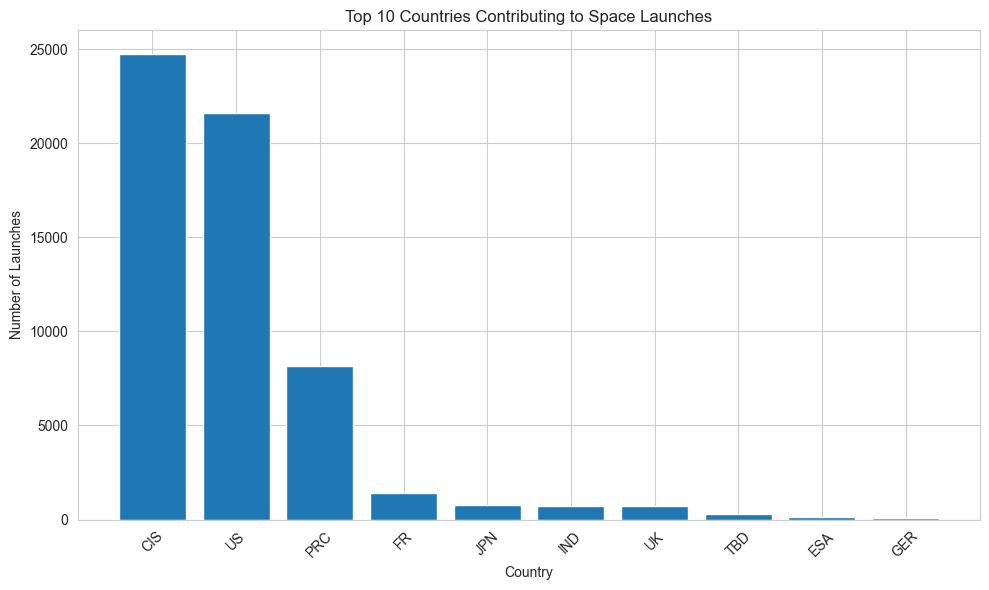

In [20]:
launch_count_by_country = df["COUNTRY"].value_counts()
print(launch_count_by_country.columns)

top_10_countries = launch_count_by_country.sort("count", descending=True).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_countries.to_pandas()['COUNTRY'], top_10_countries.to_pandas()['count'])
plt.xlabel('Country')
plt.ylabel('Number of Launches')
plt.title('Top 10 Countries Contributing to Space Launches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

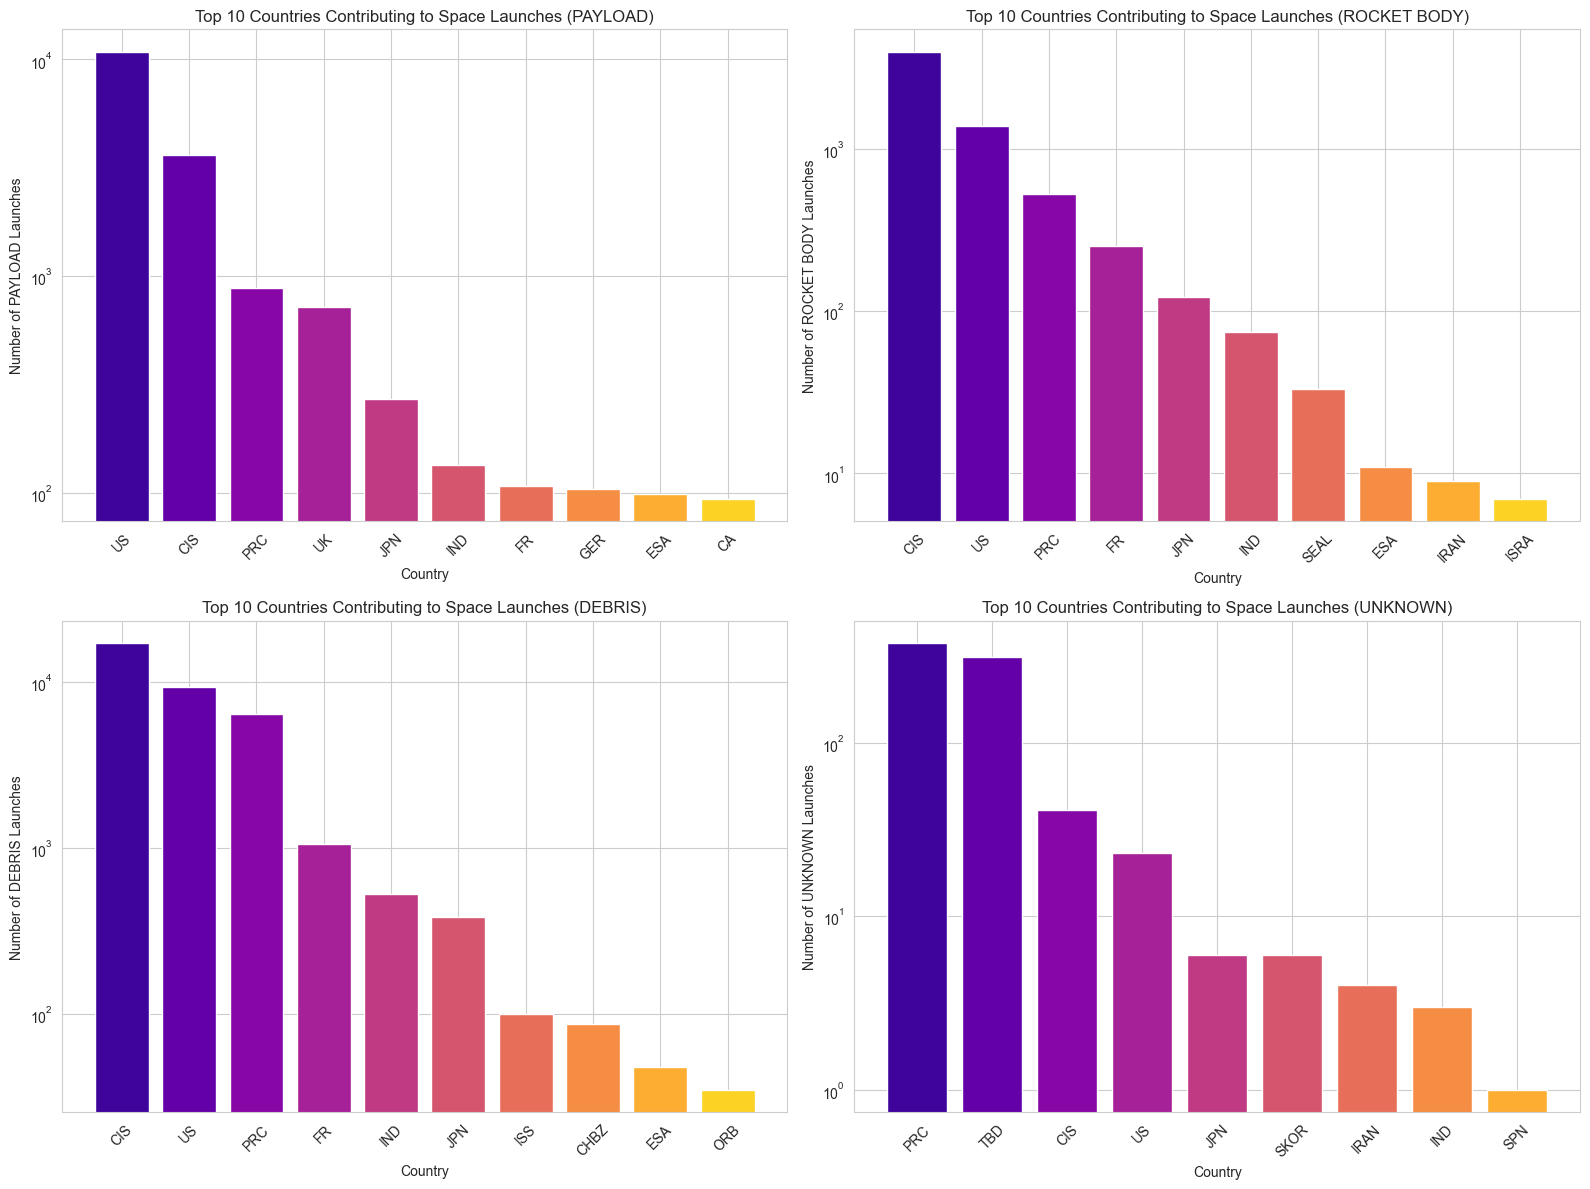

In [21]:
object_types = ['PAYLOAD', 'ROCKET BODY', 'DEBRIS', 'UNKNOWN']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
palette = sns.color_palette("plasma", len(top_10_countries))
for i, object_type in enumerate(object_types):
    filtered_df = df.filter(df["OBJECT_TYPE"] == object_type)
    launch_count_by_country = filtered_df["COUNTRY"].value_counts()
    top_10_countries = launch_count_by_country.sort("count", descending=True).head(10)

    axes[i].bar(top_10_countries.to_pandas()['COUNTRY'], top_10_countries.to_pandas()['count'], color=palette)
    axes[i].set_xlabel('Country')
    axes[i].set_ylabel(f'Number of {object_type} Launches')
    axes[i].set_title(f'Top 10 Countries Contributing to Space Launches ({object_type})')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_yscale('log')

plt.tight_layout()
plt.show()

/var/folders/h3/b9cjql916vq83y97m2p8lv9m0000gn/T/ipykernel_55923/1769011422.py:10: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  launches_by_year_df = pl.DataFrame(launches_by_year, schema=["Year", "Launches"])


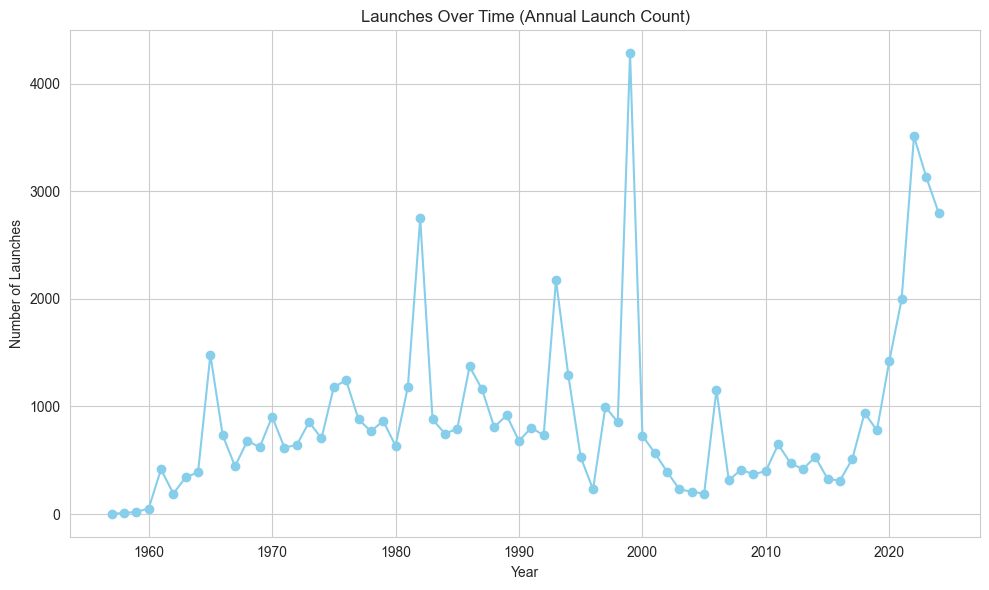

In [22]:
df = df.with_columns(pl.col("LAUNCH_YEAR").cast(pl.Int32))

unique_years = df.select(pl.col("LAUNCH_YEAR").unique()).to_pandas()['LAUNCH_YEAR']

launches_by_year = []
for year in unique_years:
    count = df.filter(pl.col("LAUNCH_YEAR") == year).height
    launches_by_year.append((year, count))

launches_by_year_df = pl.DataFrame(launches_by_year, schema=["Year", "Launches"])

plt.figure(figsize=(10, 6))
plt.plot(launches_by_year_df["Year"], launches_by_year_df["Launches"], marker='o', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.title('Launches Over Time (Annual Launch Count)')
plt.grid(True)
plt.tight_layout()
plt.show()

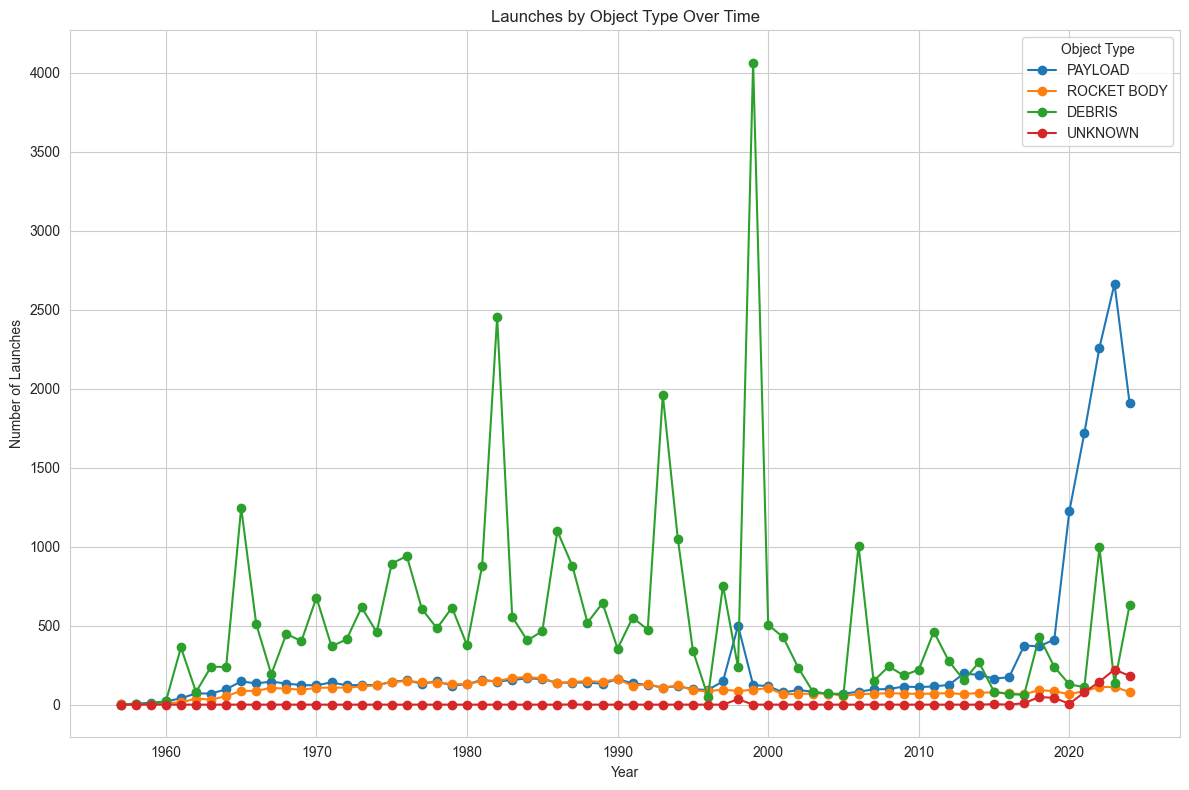

In [23]:
object_types = ['PAYLOAD', 'ROCKET BODY', 'DEBRIS', 'UNKNOWN']

plt.figure(figsize=(12, 8))
for object_type in object_types:
    launches_by_object_type = []
    for year in unique_years:
        count = df.filter((pl.col("LAUNCH_YEAR") == year) & (pl.col("OBJECT_TYPE") == object_type)).height
        launches_by_object_type.append(count)

    # Plotting each object type's launches over time
    plt.plot(unique_years, launches_by_object_type, label=object_type, marker='o')

plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.title('Launches by Object Type Over Time')
plt.legend(title='Object Type')
plt.grid(True)
plt.tight_layout()
plt.show()

## Key Findings
Some of the biggest findings from this were the distribution of different types of launches on a time series. There is a sudden increase in the number of payload launches towards the present time. There are spikes of debris being sent up in the 1980s and 90s; however, these decline towards the end of the graph. The Commonwealth of Independent States (CIS) sent up a significant portion of objects to space, leading in debris and rocket bodies. The United States sends the most payloads. Upon further research, many of these payloads come from private companies, rather than the government itself. There is also a significant disparity among the number of launches of the top four launch sites with the rest of the launch sites. An interesting topic to explore after this would be the amount of funding governmental and private organizations receive for these launches and missions.